In [1]:
from scipy.io import wavfile
import numpy as np
from scipy import signal
import librosa
import scipy
import matplotlib.pyplot as plt

In [2]:
Fs, data = wavfile.read("bonobo.wav")

In [3]:
number = 2

Odsecanje frekvencija na osnovu maske od 0 i 1

In [4]:
def mask_signal(sig_stft, sig_mask):
    sig_stft_amp = sig_stft * (1 - sig_mask)
    return sig_stft_amp


In [5]:
def remove_noise(audio_clip, noise_clip, n_fft=2048, win_length=2048, hop_length=512, n_std_thresh=1.5, prop_decrease=1.0,):
    # Racunanje STFT nad bukom (iz vremenskog u frekvencijski domen)
    noise_stft = librosa.stft(noise_clip, n_fft, hop_length, win_length)
    
    # Statistike nad bukom
    mean_freq_noise = np.mean(noise_stft, axis=1)
    std_freq_noise = np.std(noise_stft, axis=1)
    noise_thresh = mean_freq_noise + std_freq_noise * n_std_thresh
    

    # Racunanje STFT nad snimnkom
    sig_stft = librosa.stft(audio_clip, n_fft, hop_length, win_length)
    
    # Racunanje tresholda (frekvencije) za svaku vrstu stft (frekvencija/vreme)
    threshold = np.repeat(
        np.reshape(noise_thresh, [1, len(mean_freq_noise)]),
        np.shape(sig_stft)[1],
        axis=0).T
    # Kreiranje maske
    sig_mask = sig_stft < threshold

    sig_mask = sig_mask * prop_decrease
    
    # Maskiranje signala
    sig_stft_amp = mask_signal(sig_stft, sig_mask)

    # Vracanje u vremenski domen
    recovered_signal = librosa.istft(sig_stft_amp, hop_length, win_length)
    
    return recovered_signal

In [6]:
# Preuzeto sa https://stackoverflow.com/questions/33933842/how-to-generate-noise-in-frequency-range-with-numpy
# Za testiranje
def fftnoise(f):
    f = np.array(f, dtype="complex")
    Np = (len(f) - 1) // 2
    phases = np.random.rand(Np) * 2 * np.pi
    phases = np.cos(phases) + 1j * np.sin(phases)
    f[1 : Np + 1] *= phases
    f[-1 : -1 - Np : -1] = np.conj(f[1 : Np + 1])
    return np.fft.ifft(f).real

In [7]:
def band_limited_noise(min_freq, max_freq, samples=1024, samplerate=1):
    freqs = np.abs(np.fft.fftfreq(samples, 1 / samplerate))
    f = np.zeros(samples)
    f[np.logical_and(freqs >= min_freq, freqs <= max_freq)] = 1
    return fftnoise(f)

In [8]:
def merge_original_and_noise(original, noise):
    if original.shape[0] > noise.shape[0]:
        noise = np.float64(np.append(noise, np.zeros(original.shape[0] - noise.shape[0])))
    elif original.shape[0] < noise.shape[0]:
        original = np.float64(np.append(original, np.zeros(noise.shape[0] - original.shape[0])))
    return original + noise

In [9]:
Fs_noise, noise  = wavfile.read("../Dataset/NoiseSample_" + str(number) + ".wav")
noise = np.float64(noise)
print(noise.shape)
#Radicemo samo na prvom kanalu audio snimka ako je stereo
original_with_noise = merge_original_and_noise(data[:, 0], noise[:,0])

(479855, 2)


Text(0.5, 1.0, 'Originalni snimak')

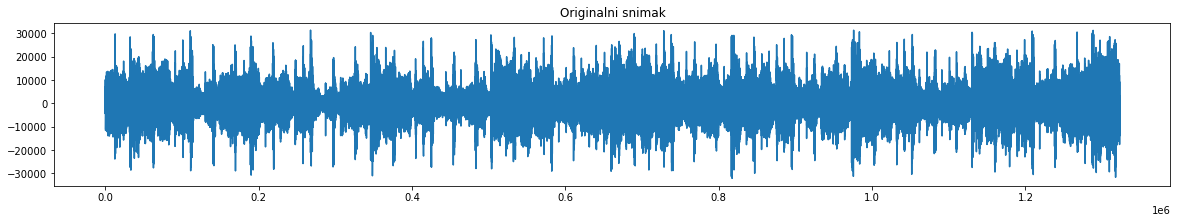

In [10]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(data[:,0])
plt.title("Originalni snimak")

Text(0.5, 1.0, 'Sum')

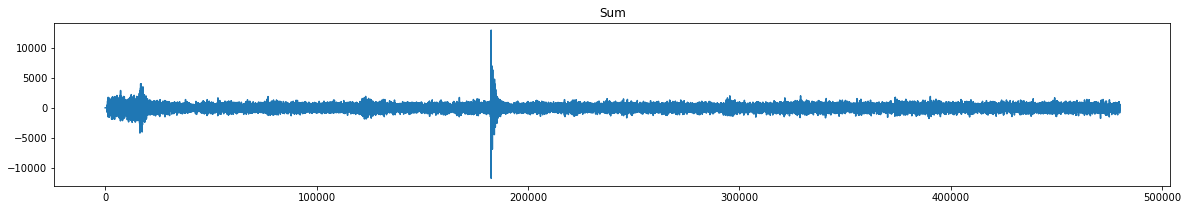

In [11]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(noise[:, 0])
plt.title("Sum")

Text(0.5, 1.0, 'Originalni sa sumom')

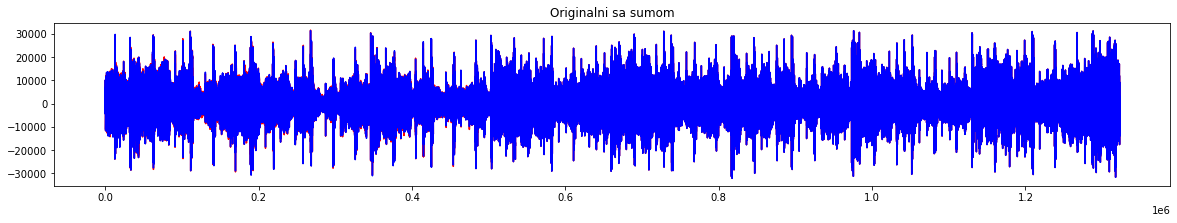

In [12]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(original_with_noise, color='red')
ax.plot(data[:, 0], color='blue')
plt.title("Originalni sa sumom")

In [13]:
noise_reduced = remove_noise(audio_clip=original_with_noise, noise_clip=noise[:,0], prop_decrease=1.0)

Text(0.5, 1.0, 'Bez suma')

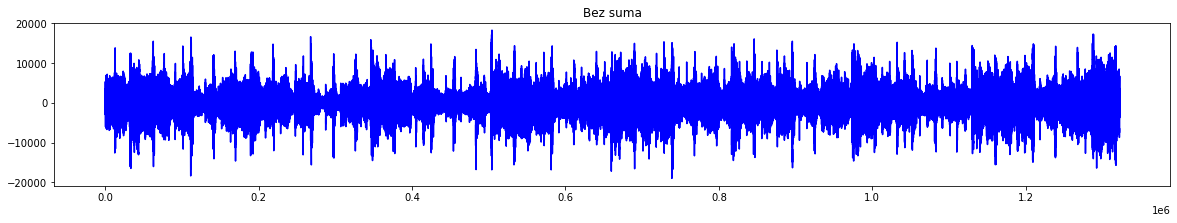

In [14]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(noise_reduced, color='blue')
plt.title("Bez suma")

In [15]:
# Resavanje curenja spektra prozorskim funkcijama
c = np.fft.fft(noise_reduced)
window = signal.windows.hamming(c.shape[0])
c = c * window

In [16]:
wavfile.write("Noise_reduced" + str(number) + ".wav", Fs, np.fft.ifft(c).astype(data[:,0].dtype))

<ipython-input-16-72ea7c9ed342>:1: ComplexWarning: Casting complex values to real discards the imaginary part
  wavfile.write("Noise_reduced" + str(number) + ".wav", Fs, np.fft.ifft(c).astype(data[:,0].dtype))


In [18]:
window = signal.windows.hamming(original_with_noise.shape[0])
wavfile.write("Song_with_noise" + str(number) + ".wav", Fs, np.fft.ifft(np.fft.fft(original_with_noise) * window).astype(data[:, 0].dtype))

<ipython-input-18-6cdb148f085a>:2: ComplexWarning: Casting complex values to real discards the imaginary part
  wavfile.write("Song_with_noise" + str(number) + ".wav", Fs, np.fft.ifft(np.fft.fft(original_with_noise) * window).astype(data[:, 0].dtype))
